In [1]:
import numpy as np
from qiskit import execute, QuantumCircuit
from qiskit.test.mock import FakeParis
from qiskit.providers.aer import QasmSimulator, noise

from qiskit.ignis.verification.tomography import marginal_counts, expectation_counts
from qiskit.ignis.mitigation.measurement import (
    MeasMitigatorGenerator,
    MeasMitigatorFitter,
    CompleteMeasMitigator,
    TensoredMeasMitigator,
    CTMPMeasMitigator,
    counts_expectation_value)

# Calibration of Mitigators

## Sim noise model

In [2]:
sim = QasmSimulator()

# Example max qubit number
num_qubits = 4

# Create readout errors
readout_errors = []
for i in range(num_qubits):
    p_error1 = (i + 1) * 0.02
    p_error0 = 2 * p_error1
    ro_error = noise.ReadoutError([[1 - p_error0, p_error0], [p_error1, 1 - p_error1]])
    readout_errors.append(ro_error)

# Readout Error only
nm = noise.NoiseModel()
for i in range(num_qubits):
    nm.add_readout_error(readout_errors[i], [i])
seed_simulator = 100

## Complete A-matrix method

In [3]:
circuits1, metadata1, _ = MeasMitigatorGenerator(num_qubits, method='complete').run()

job_cal1 = execute(circuits1, sim,
                   seed_simulator=seed_simulator,
                   shots=10000,
                   noise_model=nm,
                   backend_options={'method': 'density_matrix'})
result_cal1 = job_cal1.result()
complete_mitigator = MeasMitigatorFitter(result_cal1, metadata1).fit(method='complete')

### Properties of the calibrated mitigator
We can now look at properties of the calibrated mitigator

#### Mitigation Overhead

In [4]:
delta = 0.05
print('Mitigation Overhead:', complete_mitigator.mitigation_overhead())
print('Required Shots (delta = {}): {}'.format(delta, complete_mitigator.required_shots(delta)))

Mitigation Overhead: 6
Required Shots (delta = 0.05): 8911


#### Assignment Fidelities

We can compute the single qubit avergage assignment fidelities from the mitigator

In [5]:
print('Assignment Fidelities')
for i in range(num_qubits):
    print('Qubit {}, F_m = {:.2}'.format(i, complete_mitigator.assignment_fidelity([i])))

Assignment Fidelities
Qubit 0, F_m = 0.97
Qubit 1, F_m = 0.94
Qubit 2, F_m = 0.91
Qubit 3, F_m = 0.88


### Matrix Plots

We can also plot the full Assigment and mitigation matrices A, and inverse(A)


 Assignment Matrix

Full Mitigation Matrix


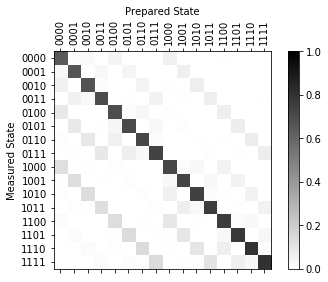

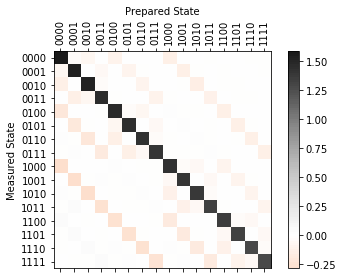

In [6]:
print('\n Assignment Matrix')
ax1 = complete_mitigator.plot_assignment_matrix()

print('\nFull Mitigation Matrix')
ax2 = complete_mitigator.plot_mitigation_matrix()

## Single-qubit Tensored A-matrix method

In [7]:
circuits2, metadata2, _ = MeasMitigatorGenerator(num_qubits, method='tensored').run()

job_cal2 = execute(circuits2, sim,
                   seed_simulator=seed_simulator,
                   shots=10000,
                   noise_model=nm,
                   backend_options={'method': 'density_matrix'})
result_cal2 = job_cal2.result()
tensored_mitigator = MeasMitigatorFitter(result_cal2, metadata2).fit(method='tensored')

### Properties of the calibrated mitigator
We can now look at properties of the calibrated mitigator

#### Mitigation Overhead

In [8]:
delta = 0.05
print('Mitigation Overhead:', tensored_mitigator.mitigation_overhead())
print('Required Shots (delta = {}): {}'.format(delta, tensored_mitigator.required_shots(delta)))

Mitigation Overhead: 6
Required Shots (delta = 0.05): 8966


#### Assignment Fidelities

We can compute the single qubit avergage assignment fidelities from the mitigator

In [9]:
print('Assignment Fidelities')
for i in range(num_qubits):
    print('Qubit {}, F_m = {:.2}'.format(i, tensored_mitigator.assignment_fidelity([i])))

Assignment Fidelities
Qubit 0, F_m = 0.97
Qubit 1, F_m = 0.94
Qubit 2, F_m = 0.91
Qubit 3, F_m = 0.88


### Matrix Plots

We can also plot the full Assigment and mitigation matrices A, and inverse(A)


 Assignment Matrix

Full Mitigation Matrix


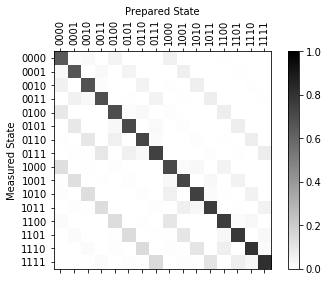

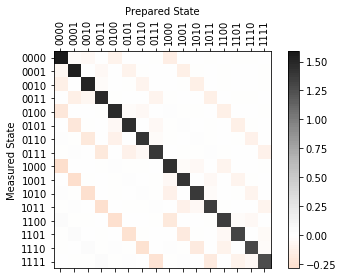

In [10]:
print('\n Assignment Matrix')
ax1 = tensored_mitigator.plot_assignment_matrix()

print('\nFull Mitigation Matrix')
ax2 = tensored_mitigator.plot_mitigation_matrix()

## Continuous-Time Markov-Process Method

In [11]:
circuits3, metadata3, _ = MeasMitigatorGenerator(num_qubits, method='CTMP').run()

job_cal3 = execute(circuits3, sim,
                   seed_simulator=seed_simulator,
                   shots=10000,
                   noise_model=nm,
                   backend_options={'method': 'density_matrix'})
result_cal3 = job_cal3.result()
ctmp_mitigator = MeasMitigatorFitter(result_cal3, metadata3).fit(method='CTMP')

### Properties of the calibrated mitigator
We can now look at properties of the calibrated mitigator

#### Mitigation Overhead

In [12]:
delta = 0.05
print('Mitigation Overhead:', ctmp_mitigator.mitigation_overhead())
print('Required Shots (delta = {}): {}'.format(delta, ctmp_mitigator.required_shots(delta)))

Mitigation Overhead: 7
Required Shots (delta = 0.05): 9766


#### Assignment Fidelities

We can compute the single qubit avergage assignment fidelities from the mitigator

In [13]:
#print('Assignment Fidelities')
#for i in range(num_qubits):
#    print('Qubit {}, F_m = {:.2}'.format(i, ctmp_mitigator.assignment_fidelity([i])))

### Matrix Plots

We can also plot the full Assigment and mitigation matrices A, and inverse(A)

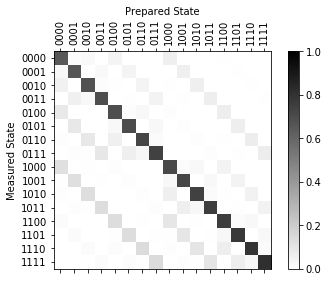

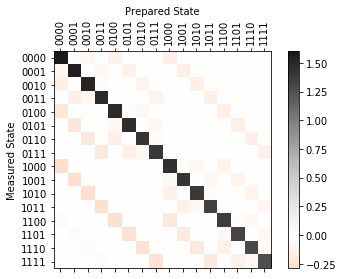

In [14]:
ax1 = ctmp_mitigator.plot_assignment_matrix()
ax2 = ctmp_mitigator.plot_mitigation_matrix()

# Error Mitigation Examples

### Expval (all-qubits)

In [15]:
# Test Circuit Measure <XXXX> stabilizer
qc = QuantumCircuit(4, 4)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.h(range(4))
qc.measure(range(4), range(4))

# Simulation
shots = 10000
result_target = execute(qc, sim, shots=shots).result()
result_noise = execute(qc, sim, shots=shots, noise_model=nm).result()
counts_target = result_target.get_counts(0)
counts_noise = result_noise.get_counts(0)

# Expvals
expvals = [
    ('Target', counts_expectation_value(counts_target)),
    ('Unmitigated', counts_expectation_value(counts_noise)),
    ('Mitigated (Complete)', complete_mitigator.expectation_value(counts_noise)),
    ('Mitigated (Tensored)', tensored_mitigator.expectation_value(counts_noise)),
    ('Mitigated (CTMP)', ctmp_mitigator.expectation_value(counts_noise)),
]
print('\nExpectation Values')
for label, expval in expvals:
    print('- {}: {:f}'.format(label, expval))


Expectation Values
- Target: 1.000000
- Unmitigated: 0.507800
- Mitigated (Complete): 0.988526
- Mitigated (Tensored): 0.990162
- Mitigated (CTMP): 0.984481


### Expval (all-qubits, permuted)

NOTE: This is not yet implemented for CTMP method

In [16]:
for meas_qubits in [[0, 1, 2, 3], [0, 1, 3, 2], [1, 3, 0, 2], [3, 0, 1, 2], [2, 0, 3, 1], [3, 2, 1, 0]]:

    # Test Circuit Measure <XXXX> stabilizer
    qc = QuantumCircuit(4, 4)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.h(range(4))
    qc.measure(meas_qubits, range(4))

    # Simulation
    shots = 10000

    result_target = execute(qc, sim, shots=shots, seed_simulator=seed_simulator).result()
    result_noise = execute(qc, sim, shots=shots,seed_simulator=seed_simulator,
                           noise_model=nm).result()
    counts_target = result_target.get_counts(0)
    counts_noise = result_noise.get_counts(0)

    # Expvals
    expvals = [
        ('Target', counts_expectation_value(counts_target)),
        ('Unmitigated', counts_expectation_value(counts_noise)),
        ('Mitigated (Complete)', complete_mitigator.expectation_value(counts_noise, qubits=meas_qubits)),
        ('Mitigated (Tensored)', tensored_mitigator.expectation_value(counts_noise, qubits=meas_qubits)),
        ('Mitigated (CTMP)', ctmp_mitigator.expectation_value(counts_noise)),
    ]
    print('\nExpectation Values (clbits: {})'.format(meas_qubits))
    for label, expval in expvals:
        print('- {}: {:f}'.format(label, expval))


Expectation Values (clbits: [0, 1, 2, 3])
- Target: 1.000000
- Unmitigated: 0.528400
- Mitigated (Complete): 1.023113
- Mitigated (Tensored): 1.024260
- Mitigated (CTMP): 1.039280

Expectation Values (clbits: [0, 1, 3, 2])
- Target: 1.000000
- Unmitigated: 0.519600
- Mitigated (Complete): 1.005603
- Mitigated (Tensored): 1.006836
- Mitigated (CTMP): 1.014480

Expectation Values (clbits: [1, 3, 0, 2])
- Target: 1.000000
- Unmitigated: 0.524600
- Mitigated (Complete): 1.016037
- Mitigated (Tensored): 1.017316
- Mitigated (CTMP): 1.038080

Expectation Values (clbits: [3, 0, 1, 2])
- Target: 1.000000
- Unmitigated: 0.522000
- Mitigated (Complete): 1.012298
- Mitigated (Tensored): 1.013475
- Mitigated (CTMP): 0.998481

Expectation Values (clbits: [2, 0, 3, 1])
- Target: 1.000000
- Unmitigated: 0.516000
- Mitigated (Complete): 1.001812
- Mitigated (Tensored): 1.002961
- Mitigated (CTMP): 1.008281

Expectation Values (clbits: [3, 2, 1, 0])
- Target: 1.000000
- Unmitigated: 0.518400
- Mitigat

### Expval Partial Qubits

NOTE: This is not yet implemented for CTMP method

In [17]:
for qubits in [[0, 1], [0, 2], [0, 3], [3, 1], [2, 1], [3, 2], [2, 3]]:
    
    # Test Circuit
    qc = QuantumCircuit(4, 2)
    qc.h(qubits[0])
    qc.cx(qubits[0], qubits[1])
    qc.measure(qubits, [0, 1])

    # Simulation
    shots = 8000
    seed = 1101
    result_target = execute(qc, sim, shots=shots, seed_simulator=seed_simulator).result()
    result_noise = execute(qc, sim, shots=shots,seed_simulator=seed_simulator,
                           noise_model=nm).result()
    counts_target = result_target.get_counts(0)
    counts_noise = result_noise.get_counts(0)

    # Expvals
    expvals = [
        ('Target', counts_expectation_value(counts_target)),
        ('Unmitigated', counts_expectation_value(counts_noise)),
        ('Mitigated (Complete)', complete_mitigator.expectation_value(counts_noise, qubits=qubits)),
        ('Mitigated (Tensored)', tensored_mitigator.expectation_value(counts_noise, qubits=qubits)),
        ('Mitigated (CTMP)', ctmp_mitigator.expectation_value(counts_noise)),
    ]
    print('\nExpectation Values (qubits: {})'.format(qubits))
    for label, expval in expvals:
        print('- {}: {:f}'.format(label, expval))


Expectation Values (qubits: [0, 1])
- Target: 1.000000
- Unmitigated: 0.827000
- Mitigated (Complete): 0.995536
- Mitigated (Tensored): 0.993151
- Mitigated (CTMP): 1.388723

Expectation Values (qubits: [0, 2])
- Target: 1.000000
- Unmitigated: 0.765250
- Mitigated (Complete): 0.992570
- Mitigated (Tensored): 0.996523
- Mitigated (CTMP): 1.311225

Expectation Values (qubits: [0, 3])
- Target: 1.000000
- Unmitigated: 0.712000
- Mitigated (Complete): 0.996379
- Mitigated (Tensored): 0.999200
- Mitigated (CTMP): 1.195477

Expectation Values (qubits: [3, 1])
- Target: 1.000000
- Unmitigated: 0.668250
- Mitigated (Complete): 0.993435
- Mitigated (Tensored): 0.990186
- Mitigated (CTMP): 1.127978

Expectation Values (qubits: [2, 1])
- Target: 1.000000
- Unmitigated: 0.723000
- Mitigated (Complete): 1.000481
- Mitigated (Tensored): 0.994870
- Mitigated (CTMP): 1.223976

Expectation Values (qubits: [3, 2])
- Target: 1.000000
- Unmitigated: 0.617500
- Mitigated (Complete): 0.991132
- Mitigated 